In [1]:
# Imports
import numpy as np
from pydrake.all import *
from IPython.display import display, SVG, clear_output, HTML

from manipulation.meshcat_cpp_utils import(
    StartMeshcat, MeshcatJointSlidersThatPublish)
from manipulation.scenarios import AddMultibodyTriad

# Import pygmo for optimisation
import pygmo as pg
# from urdf_creator import *
from urdf_creator_struct import *
import time
from joblib import Parallel, delayed
from utils import *

# Import for structures 
import json
from operator import itemgetter
import torch

In [2]:
meshcat = StartMeshcat()

In [4]:
# Load the classifiers
clf = joblib.load('./feasibility_classifier.pkl')
# Load mean and scale data
fit_file = open('./mean_and_scale.json')
fit_params = json.load(fit_file)
fit_file.close()

In [5]:
# Define the number of actuators
na = 7

# GLOBAL PROBLEM SETUP

# Reference: https://wiki.ros.org/pr2_controller_manager/safety_limits
# Defining the actuator box
class ActuatorBox(LeafSystem):
    # Input values are for motor and NOT for the joint
    def __init__(self, tau_max_m, omega_max_m, gear_ratio, k_velocity):
        LeafSystem.__init__(self)
        # Both the values are motor specific and NOT joint specific
        # Get joint max torque
        self.tau_max_j = tau_max_m*gear_ratio
        self.k_vel = k_velocity
        # Convert RPM of motor to joint velocity in rad/sec
        self.omega_max_j = omega_max_m*(2*np.pi/60)/gear_ratio
        self.DeclareVectorInputPort('commanded_torque', BasicVector(na))
        self.DeclareVectorInputPort('joint_state', BasicVector(2*na))
        self.DeclareVectorOutputPort('realised_torque', BasicVector(na), self.OutputJointTorque)

    def OutputJointTorque(self, context, output):
        # Get the state values
        q = self.EvalVectorInput(context, 1).get_value()
        qvel = q[na:]
        u = self.EvalVectorInput(context, 0).get_value()
        # Compute the instantaneous torque limit
        # For the AK-70-10 motors
        kv = self.k_vel
        u_new = np.copy(u)
        # Using URDF safety controller rules
        for i in range(len(u)):
            if qvel[i]>=0 and u[i]>=0:
                u_bound = -kv*(qvel[i]-self.omega_max_j)
                u_new[i] = np.min([u[i], u_bound, self.tau_max_j])
            if qvel[i]>=0 and u[i]<=0:
                u_bound = -self.tau_max_j
                u_new[i] = np.max([u[i], u_bound])
            if qvel[i]<=0 and u[i]>=0:
                u_bound = self.tau_max_j
                u_new[i] = np.min([u[i], u_bound])
            if qvel[i]<=0 and u[i]<=0:
                u_bound = -(-kv*(np.abs(qvel[i])-self.omega_max_j))
                u_new[i] = np.max([u[i], u_bound, -self.tau_max_j])
#             print(u[i], u_bound, u_new[i])
        output.SetFromVector(u_new)

# Task definition
# Home position
q0 = np.array([-0.64, -0.35, -1.01,  1.7, -0.29 ,0.88, -0.034])
# carti = np.array([-0.1, 0.14, 0.85])
# qi = np.array([0.96, 0.44])
# q0 = qi
# cartd = np.array([-0.1, 0.32, 1.29])
# qd = np.array([-0.53, 0.58])
# qint = qd

carti = np.array([-0.53, 0.13, 0.81])
cartd = np.array([-0.23, 0.24, 1.03])

# Simulation settings
time_step = 1e-4
sim_time = 5
error_threshold = 5e-3

# Robot URDF
urdf_path = './urdfs/divar3v7308465156.urdf'
print(urdf_path)

# motor mass
m_m = 0.452
# Assumed values
tau_mu = 5.3e-3
b0 = 1.5e-5
# AK70-10 parameters
# gear ratio
gear_ratio = 10
# motor design variables
tau_max_m = 12/gear_ratio # Nm
omega_max_m = 475*gear_ratio   # RPM
Kt = 0.095        # Nm/A
Kv = 100          # RPM/V
Km = 0.19         # Nm/sqrt(W)
# Computed matrix for joule loss
K_joule = 1/np.sqrt(Km)*np.identity(na)
k_velocity = 8.33/(75*2*np.pi/60) # Nm/(rad/s)
# Control attributes
Kp = 15
Kd = 2*np.sqrt(Kp)
max_penal = 1e4

study = ["baseline_control", "baseline_motor", "baseline_codesign", "baseline_codesign_heuristics", "baseline"]

case = study[2]
if case=="baseline_control":
    # For baseline-control study
    pre_val_vals = [tau_mu, b0, Km, k_velocity, tau_max_m, omega_max_m, gear_ratio, m_m]
    pre_val_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "m_m"]
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["Kp", "Kd"]
    print(case)
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [15, 2*np.sqrt(15)]
    print(sample_dv)
    dv_bounds = ([0,0],[100,100])
    print('dv_bounds: ', dv_bounds)
    
if case=="baseline_motor":
    # For baseline-control-motor study
    pre_val_vals = []
    pre_val_names = []
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m"]
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [0.0053, 1.5e-05, 0.19, 1.0606085407643906, 1.2, 4750, 10, 15, 2*np.sqrt(15), 0.452]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([0,0,0,1e-2,1e-3,1000,0.1, 0, 0, 0],[1,1,5,1e2,5,9000,25,100,100,5])
    print('dv_bounds: ', dv_bounds)
    
if case=="baseline_codesign":
    # For baseline-codesign study
    pre_val_vals = []
    pre_val_names = []
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m", "a1", "lua","a23_distr", "lfa", "a45_distr", "a7","k1","k2","k3"]
    task_info = {'carti': carti, 'cartd': cartd}
    pre_val.update(task_info)
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [0.0053, 1.5e-05, 0.19, 1.0606085407643906, 1.2, 4750, 10, 15, 2*np.sqrt(15), 0.452, 0.36, 0.36, 0.5, 0.36, 0.5, 0.36,646.2338,69400000,56100000]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([0,0,1e-3,1e-2,1e-3,1000,0.1, 1e-4, 1e-4, 1e-3,0.1,0.1,0.05,0.1,0.05,0.1,100,100,100],[1e-2,1e-2,5,25,3,9000,25,100,100,2,0.3,0.5,0.95,0.5,0.95,0.25,30900,379000000,379000000])
    print('dv_bounds: ', dv_bounds)
#     {'tau_mu': 0.0053, 'b0': 1.5e-05, 'Km': 0.19, 'k_velocity': 1.0606085407643906, 'tau_max_m': 1.2, 'omega_max_m': 4750, 'gear_ratio': 10, 'Kp': 15, 'Kd': 7.745966692414834, 'm_m': 0.452, 'a1': 0.36, 'lua': 0.36, 'a23_distr': 0.5, 'lfa': 0.36, 'a45_distr': 0.5, 'a7': 0.36, 'k1': 646.2338, 'k2': 69400000, 'k3': 56100000}


    # Limited heuristics available from the paper
if case=="baseline_codesign_heuristics":
    # For baseline-codesign study
    pre_val_names = ["tau_mu", "b0", "k_velocity"]
    pre_val_vals = [0.0053, 1.5e-05, 1.0606085407643906]
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["omega_max_m", "gear_ratio", "Kp", "Kd", "m_m", "l1", "l2"]
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [4750, 10, 15, 2*np.sqrt(15), 0.452, 0.36, 0.36]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([1000,0.1, 0, 0, 1e-3,1e-2,1e-2],[9000,25,100,100,5,2,2])
    print('dv_bounds: ', dv_bounds)  
    
if case=="baseline":
    print(case)
    # For simulation study
    pre_val_vals = [tau_mu, b0, Km, k_velocity, tau_max_m, omega_max_m, gear_ratio, Kp, Kd, m_m]
    pre_val_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m"]
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = []
    sample_dv = []
    task_info = {'carti': carti, 'cartd': cartd}
    pre_val.update(task_info)
    print(pre_val)

./urdfs/divar3v7308465156.urdf
baseline_codesign
pre_val:  {'carti': array([-0.53,  0.13,  0.81]), 'cartd': array([-0.23,  0.24,  1.03])} dv_names:  ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m', 'a1', 'lua', 'a23_distr', 'lfa', 'a45_distr', 'a7', 'k1', 'k2', 'k3']
Sample-DV:  [0.0053, 1.5e-05, 0.19, 1.0606085407643906, 1.2, 4750, 10, 15, 7.745966692414834, 0.452, 0.36, 0.36, 0.5, 0.36, 0.5, 0.36, 646.2338, 69400000, 56100000]
dv_bounds:  ([0, 0, 0.001, 0.01, 0.001, 1000, 0.1, 0.0001, 0.0001, 0.001, 0.1, 0.1, 0.05, 0.1, 0.05, 0.1, 100, 100, 100], [0.01, 0.01, 5, 25, 3, 9000, 25, 100, 100, 2, 0.3, 0.5, 0.95, 0.5, 0.95, 0.25, 30900, 379000000, 379000000])


In [6]:
# ADD INDIVIDUAL STIFFNESSES TO ALL THE LINKS

link_lengths = np.array([0.3,0.25,0.25,0.2,0.3,0.25])
kvals = np.array([0,0,0])
input_list = np.c_[np.array([kvals,]*6), link_lengths*1000]
input_list_torch = torch.from_numpy(input_list)
feas_mean = np.array(fit_params['feas_data']['mean'])
feas_scale = np.array(fit_params['feas_data']['scale'])
norm_input_list = (input_list_torch-feas_mean)/feas_scale
pred_feas = clf.predict(norm_input_list.cpu().numpy())

In [7]:
clf.predict(norm_input_list.cpu().numpy())

array([1., 1., 1., 1., 1., 1.])

In [8]:
pred_feas

array([1., 1., 1., 1., 1., 1.])

In [9]:
def compute_QoI(pre_val, dv_names, sample_dv, case, clf, fit_params, run_sim=False):
    # Construct the master dv list
    dv_dict = dict(zip(dv_names, sample_dv))
    if case==study[3]:
        # Map the entire design space from the sampled DVs using heuristics
        # Current heuristics used are from the jump paper
        dv_dict['tau_max_m'] = 5.48*dv_dict['m_m']**0.97
        dv_dict['Km'] = 0.15*dv_dict['m_m']**1.39
        # Later also fit k_velocity values
    dv = {**pre_val, **dv_dict}
    # Construct a new URDF if its such a case
#     print(case)
    if (case==study[1]) or (case==study[2]) or (case==study[3]):
        urdf_path, updated_dv =urdf_creator(dv, fit_params)
        dv = updated_dv
    else:
        urdf_path = './urdfs/divar3v7308465156.urdf'
    # Construct the sim diagram
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    print(urdf_path)
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1.2]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
    if run_sim:
#         print(urdf_path)
        meshcat.Delete()
        meshcat.DeleteAddedControls()
        # Spawn table
        table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')

    # Due to the way the problem is formulated, spheres and the table can be safely ignored
    plant.Finalize()
    actuator = builder.AddSystem(ActuatorBox(dv['tau_max_m'], dv['omega_max_m'], dv['gear_ratio'], dv['k_velocity']))
    
    if run_sim:
        visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    
    # Initialise controller params, for now limited to Kp and Kd search
    Kp = np.full(na, dv['Kp'])
    Ki = np.full(na, 0)
    Kd = np.full(na, dv['Kd'])
    
    iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
    iiwa_controller.set_name("iiwa_controller");
    # Complete connections
    builder.Connect(plant.get_state_output_port(model),
                iiwa_controller.get_input_port_estimated_state())
    builder.Connect(iiwa_controller.get_output_port_control(), 
                actuator.get_input_port(0))
    builder.Connect(plant.get_state_output_port(model),
                actuator.get_input_port(1))
    builder.Connect(actuator.get_output_port(), plant.get_actuation_input_port())
    
    # Connecting a data logger
    # Commanded torque
    logger1 = LogVectorOutput(iiwa_controller.get_output_port_control(), builder)
    # Joint state
    logger2 = LogVectorOutput(plant.get_state_output_port(model), builder)
    # Realised torque
    logger3 = LogVectorOutput(actuator.get_output_port(), builder)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    gripper_frame = plant.GetBodyByName("eef").body_frame()
    
    # Feasibility check
    link_lengths = np.array(itemgetter('a1', 'a2', 'a3', 'a4', 'a5', 'a7')(dv))
    kvals = itemgetter('k1', 'k2', 'k3')(dv)
    input_list = np.c_[np.array([kvals,]*6), link_lengths*1000]
    input_list_torch = torch.from_numpy(input_list)
    feas_mean = np.array(fit_params['feas_data']['mean'])
    feas_scale = np.array(fit_params['feas_data']['scale'])
    norm_input_list = (input_list_torch-feas_mean)/feas_scale
    pred_feas = clf.predict(norm_input_list.cpu().numpy())
    if pred_feas.all():
        feasibility = 0

        # DEFLECTION
        lx = input_list[:,-1]
        ncomp = len(input_list)
        Kc = np.empty([input_list.shape[1],input_list.shape[1],input_list.shape[0]])
        for n in range(ncomp):
            K_cs1_1 = input_list[n][0]
            K_cs2_2 = input_list[n][1]
            K_cs4_4 = input_list[n][2]

            Kc[:,:,n] = np.array([[K_cs1_1,(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),-K_cs1_1,(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n])],
            [(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),K_cs2_2, -(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),   (K_cs1_1*lx[n]**2)/2 - K_cs2_2/2 - K_cs4_4/2],
            [-K_cs1_1, -(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),K_cs1_1, -(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n])],
            [(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n]),(K_cs1_1*lx[n]**2)/2 - K_cs2_2/2 - K_cs4_4/2, -(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n]),K_cs4_4]])

        # Initialising global variables
        Kg = np.zeros([(ncomp+1)*2,(ncomp+1)*2])
        Dg = np.zeros([(ncomp+1)*2,1])
        Fg = np.zeros([(ncomp+1)*2,1])
        # Constructing the global stiffness matrix
        for elx in range(ncomp):
            n1 = 2*elx
            n2 = 2*(elx+1)
            Kg[n1:n2+2, n1:n2+2] += Kc[:,:,elx]
        # Computing the displacements given the loading
        Fg[ncomp*2] = 10
        Dg = np.linalg.inv(Kg[2:,2:])@Fg[2:]
        deflection = np.max(np.abs(Dg))

    else:
        feasibility = max_penal
        deflection = max_penal
    
    # Now computing the QoIs
    # WORKSPACE
    # Workspace is always satisfied since its the same robot
    # Compute IK - pos1
    ik = InverseKinematics(plant, plant_context)
    ik.AddPositionConstraint(
                gripper_frame, [0, 0, 0], plant.world_frame(),
                dv['carti'], dv['carti'])
    # Adding the orientation constraint to keep the end-effector
    # perpendicular to the table
    ik.AddOrientationConstraint(gripper_frame, 
                                RotationMatrix(), 
                                plant.world_frame(),
                               RollPitchYaw([-3.14, 0, 0]).ToRotationMatrix(), 0.0)
    
    prog = ik.get_mutable_prog()
    q = ik.q()
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    qi = result.GetSolution(ik.q())
    qi = (np.arctan2(np.sin(qi), np.cos(qi)))
    plant.SetPositions(plant.GetMyContextFromRoot(context),model,qi)
    eef_pos_realised = plant.GetBodyByName('eef').EvalPoseInWorld(plant_context).translation()
    w1 = np.linalg.norm(eef_pos_realised-dv['carti'])
    
    # Compute IK - pos2
    ik = InverseKinematics(plant, plant_context)
    ik.AddPositionConstraint(
                gripper_frame, [0, 0, 0], plant.world_frame(),
                dv['cartd'], dv['cartd'])
    ik.AddOrientationConstraint(gripper_frame, 
                                RotationMatrix(), 
                                plant.world_frame(),
                               RollPitchYaw([-3.14, 0, 0]).ToRotationMatrix(), 0.0)
    prog = ik.get_mutable_prog()
    q = ik.q()
    prog.AddQuadraticErrorCost(np.identity(len(q)), qi, q)
    prog.SetInitialGuess(q, qi)
    result = Solve(ik.prog())
    qd = result.GetSolution(ik.q())
    qd = (np.arctan2(np.sin(qd), np.cos(qd)))
    plant.SetPositions(plant.GetMyContextFromRoot(context),model,qd)
    eef_pos_realised = plant.GetBodyByName('eef').EvalPoseInWorld(plant_context).translation()
    w2 = np.linalg.norm(eef_pos_realised-dv['cartd'])
    # Compute the error in positions    
    workspace = w1+w2
    # APPLIED FORCE
    # Applied force will also remain the same given that the tau_max is fixed
    applied_force = 0
    # PAYLOAD
    # same as applied force
    payload = 0
    # Setup the simulation
    xd = np.hstack((qd, 0*qd))
    plant.SetPositions(plant_context, qi)
    iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), xd);
    # Simulation
    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(sim_time);
    
    # Now we want to get the simulation data, i.e., 
    # the torque applied, final time of the joint variables
    log1 = logger1.FindLog(context)
    log2 = logger2.FindLog(context)
    log3 = logger3.FindLog(context)
    
    error = np.abs(log2.data()[:na,:].transpose() - np.tile(qd,(log3.data().shape[1],1)))
    e_norm = np.array([np.linalg.norm(val) for val in error])
    for i in range(len(e_norm)):
        if np.all(e_norm[i:]<error_threshold):
            break
    final_error = e_norm[-1]
    # CYCLE TIME
    ts = log2.sample_times()[i]
    
    omega_j = []
    for i in range(log2.data().shape[1]):
        omega_j.append(log2.data()[:,i][na:])
    omega_j = np.array(omega_j).transpose()
    omega_m = omega_j*dv['gear_ratio']
    # Convert the motor speed to RPM
    omega_m_rpm = omega_m*60/(2*np.pi)
    # Motor torque realised
    tau_m = log3.data()/dv['gear_ratio']
    
    K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
    # Total power losses
    inst_friction_power = []
    inst_joule_power = []
    for i in range(len(log3.sample_times())):
        omega_inst = omega_m[:, i]
        tau_f = dv['tau_mu']*np.sign(omega_inst)+dv['b0']*omega_inst
        P_f = np.dot(tau_f, omega_inst)
        inst_friction_power.append(P_f)
        tau_t = tau_f+tau_m[:, i]
        P_t = np.dot(K_joule.dot(tau_t), tau_t)
        inst_joule_power.append(P_t)
    
    # POWER LOSSES
    total_friction_loss = np.sum(inst_friction_power)*time_step
    total_joule_loss = np.sum(inst_joule_power)*time_step
    
    results = np.array([workspace, feasibility, deflection, payload, ts, total_friction_loss, total_joule_loss, final_error])
#     print(results)
    
    if run_sim:
        # Angular angular velocity of the motors in RPM
        motor_rpm = omega_j*gear_ratio*60/(2*np.pi)
        plt.plot(log2.sample_times(), motor_rpm[0, :], log2.sample_times(), motor_rpm[1, :])
        plt.title('motor RPM vs time')

        # Motor torque demanded
        fig = plt.figure()
        plt.plot(log1.sample_times(), log1.data()[0, :], log1.sample_times(), log1.data()[1, :])
        plt.title("motor torque demanded vs time")

        # Motor torque demanded
        fig = plt.figure()
        plt.plot(log1.sample_times(), log3.data()[0, :], log1.sample_times(), log3.data()[1, :])
        plt.title("motor torque realised vs time")

        print('Max realised torque', np.max(np.abs(log3.data())))

    return results

In [11]:
# sample_dv = {'tau_mu': 0.0053, 'b0': 1.5e-05, 'Km': 0.19, 'k_velocity': 1.0606085407643906, 'tau_max_m': 1.2, 'omega_max_m': 4750, 'gear_ratio': 10, 'Kp': 15, 'Kd': 7.745966692414834, 'm_m': 0.452, 'a1': 0.36, 'lua': 0.36, 'a23_distr': 0.5, 'lfa': 0.36, 'a45_distr': 0.5, 'a7': 0.36, 'k1': 646.2338, 'k2': 69400000, 'k3': 56100000}
# urdf_creator(sample_dv, fit_params)
dv_names

['tau_mu',
 'b0',
 'Km',
 'k_velocity',
 'tau_max_m',
 'omega_max_m',
 'gear_ratio',
 'Kp',
 'Kd',
 'm_m',
 'a1',
 'lua',
 'a23_distr',
 'lfa',
 'a45_distr',
 'a7',
 'k1',
 'k2',
 'k3']

./urdfs/AutoGen/divar3v8684258059.urdf
Max realised torque 1.0


array([1.26221545e-10, 1.00000000e+04, 1.00000000e+04, 0.00000000e+00,
       5.00000000e+00, 0.00000000e+00, 1.82181608e+01, 1.94980698e+01])

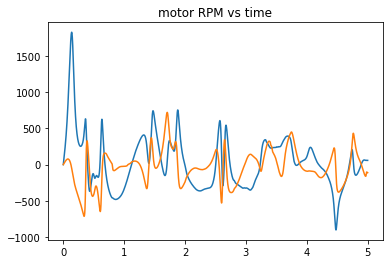

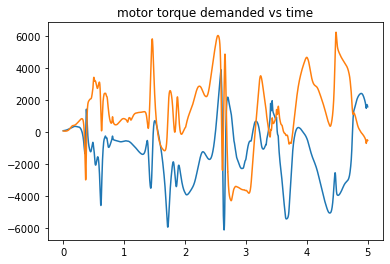

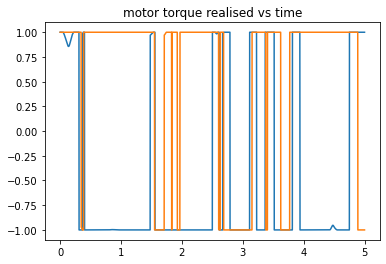

In [16]:
# test with a sample or for sim
sample_dv_2 = [0, 0, 3.35, 0.01, 1, 1000, 1, 100, 18.86, 1.07, 0.1, 0.5, 0.486, 0.5, 0.95, 0.25,30900, 100, 379000000]
# print(sample_dv_2)
compute_QoI(pre_val, dv_names, sample_dv_2, case, clf, fit_params, run_sim=True)

In [68]:
# Setting up a problem
class Baseline_Problem:
    def __init__(self, pre_val, dv_names, dv_bounds, case, clf, fit_params):
        self.pre_val = pre_val
        self.dv_names = dv_names
        self.dv_bounds = dv_bounds
        self.case = case
        self.clf = clf
        self.fit_params = fit_params
        pass

    def fitness(self,sample_dv):
        # print(sample_dv)
        # Write a function to output the QoI values
        results = compute_QoI(self.pre_val, self.dv_names, sample_dv, self.case, self.clf, self.fit_params)
        # Add weighting factor, K_w
        # workspace, feasibility, deflection, payload, ts, total_friction_loss, total_joule_loss, final_error
        K_w = np.diag([1,1,10,1,100,5,5,0])
        # Quadratic objective meta function with weights
        fitness_val = np.matmul(K_w, results).dot(results)
        return [fitness_val]

    def get_bounds(self):
        # Define bounds on the controller variables
        # Ideally from a csv file like before so that one can easily extend the optimisation problem
        return self.dv_bounds

    def get_name(self):
        # get the name of the problem also from the csv sheet
        return "Baseline_Codesign"

In [69]:
# Using CMA-ES
prob = pg.problem(Baseline_Problem(pre_val, dv_names, dv_bounds, case, clf, fit_params))
algo = pg.algorithm(pg.cmaes(gen = 3, sigma0=0.3, force_bounds=True))
algo.set_verbosity(100)

# Writing a custom island to see if we can make it work
# The default mp_island fails because of the pickle error from PyCapsule
# caused by drake AddMultibodyPlantSceneGraph function
class cool_isl:
    def run_evolve(self, algo, pop):
        # Island serially runs to evolve the pop
        new_pop = algo.evolve(pop)
        return algo, new_pop
    def get_name(self):
        return "This is a cool island that works"  

In [30]:
%%time
# Atleast we have a bfe to spawn the initial pop
# Since the evolve method is the core for optimisation there 
# is nothing I can do to parallelise that part
# archi = pg.archipelago(n=1, algo = algo, prob=prob, pop_size=30, b = pg.default_bfe(), udi = cool_isl())
archi = pg.archipelago(n=1, algo = algo, prob=prob, pop_size=300, udi = cool_isl())
archi.evolve();
archi.wait_check()

./urdfs/AutoGen/divar3v5263311697.urdf
./urdfs/AutoGen/divar3v2148105361.urdf
./urdfs/AutoGen/divar3v3751894665.urdf
./urdfs/AutoGen/divar3v5482944558.urdf
./urdfs/AutoGen/divar3v7667619568.urdf
./urdfs/AutoGen/divar3v8369628978.urdf
./urdfs/AutoGen/divar3v8779767798.urdf
./urdfs/AutoGen/divar3v668637983.urdf
./urdfs/AutoGen/divar3v8729524354.urdf
./urdfs/AutoGen/divar3v8855219608.urdf
./urdfs/AutoGen/divar3v3433454978.urdf
./urdfs/AutoGen/divar3v4564117886.urdf
./urdfs/AutoGen/divar3v2497309560.urdf
./urdfs/AutoGen/divar3v5871927027.urdf
./urdfs/AutoGen/divar3v4472323158.urdf
./urdfs/AutoGen/divar3v9239652383.urdf
./urdfs/AutoGen/divar3v1851360093.urdf
./urdfs/AutoGen/divar3v9046580979.urdf
./urdfs/AutoGen/divar3v5539306585.urdf
./urdfs/AutoGen/divar3v7018810232.urdf
./urdfs/AutoGen/divar3v5311460278.urdf
./urdfs/AutoGen/divar3v4242396375.urdf
./urdfs/AutoGen/divar3v4072025958.urdf
./urdfs/AutoGen/divar3v8586923776.urdf
./urdfs/AutoGen/divar3v7872287487.urdf
./urdfs/AutoGen/divar3v123

./urdfs/AutoGen/divar3v7276740251.urdf
./urdfs/AutoGen/divar3v5079515370.urdf
./urdfs/AutoGen/divar3v3741067679.urdf
./urdfs/AutoGen/divar3v6651981331.urdf
./urdfs/AutoGen/divar3v967169090.urdf
./urdfs/AutoGen/divar3v4954010162.urdf
./urdfs/AutoGen/divar3v8814091615.urdf
./urdfs/AutoGen/divar3v6999423534.urdf
./urdfs/AutoGen/divar3v4490343747.urdf
./urdfs/AutoGen/divar3v5171564409.urdf
./urdfs/AutoGen/divar3v7638853052.urdf
./urdfs/AutoGen/divar3v4823530755.urdf
./urdfs/AutoGen/divar3v4115704269.urdf
./urdfs/AutoGen/divar3v1922313146.urdf
./urdfs/AutoGen/divar3v3001625212.urdf
./urdfs/AutoGen/divar3v6029947219.urdf
./urdfs/AutoGen/divar3v2449106914.urdf
./urdfs/AutoGen/divar3v2732154629.urdf
./urdfs/AutoGen/divar3v6127514415.urdf
./urdfs/AutoGen/divar3v7954658624.urdf
./urdfs/AutoGen/divar3v3491069055.urdf
./urdfs/AutoGen/divar3v2479534308.urdf
./urdfs/AutoGen/divar3v3672600822.urdf
./urdfs/AutoGen/divar3v359956982.urdf
./urdfs/AutoGen/divar3v182481226.urdf
./urdfs/AutoGen/divar3v28800

./urdfs/AutoGen/divar3v5327916866.urdf
./urdfs/AutoGen/divar3v9185806097.urdf
./urdfs/AutoGen/divar3v5737528565.urdf
./urdfs/AutoGen/divar3v9834174830.urdf
./urdfs/AutoGen/divar3v5527247613.urdf
./urdfs/AutoGen/divar3v8267454445.urdf
./urdfs/AutoGen/divar3v7289696261.urdf
./urdfs/AutoGen/divar3v3761256957.urdf
./urdfs/AutoGen/divar3v5793788004.urdf
./urdfs/AutoGen/divar3v103155244.urdf
./urdfs/AutoGen/divar3v8208951284.urdf
./urdfs/AutoGen/divar3v491693224.urdf
./urdfs/AutoGen/divar3v3926410702.urdf
./urdfs/AutoGen/divar3v8115192285.urdf
./urdfs/AutoGen/divar3v7082535737.urdf
./urdfs/AutoGen/divar3v8126894685.urdf
./urdfs/AutoGen/divar3v824401080.urdf
./urdfs/AutoGen/divar3v2003669343.urdf
./urdfs/AutoGen/divar3v2219164063.urdf
./urdfs/AutoGen/divar3v2262159869.urdf
./urdfs/AutoGen/divar3v9035425003.urdf
./urdfs/AutoGen/divar3v5875395945.urdf
./urdfs/AutoGen/divar3v3109869846.urdf
./urdfs/AutoGen/divar3v5946404.urdf
./urdfs/AutoGen/divar3v3772945951.urdf
./urdfs/AutoGen/divar3v69255764

./urdfs/AutoGen/divar3v4942607218.urdf
./urdfs/AutoGen/divar3v4268021299.urdf
./urdfs/AutoGen/divar3v7662764620.urdf
./urdfs/AutoGen/divar3v2249538546.urdf
./urdfs/AutoGen/divar3v5391709617.urdf
./urdfs/AutoGen/divar3v8008853824.urdf
./urdfs/AutoGen/divar3v1874097469.urdf
./urdfs/AutoGen/divar3v957577582.urdf
./urdfs/AutoGen/divar3v3001419121.urdf
./urdfs/AutoGen/divar3v7859987829.urdf
./urdfs/AutoGen/divar3v7613441009.urdf
./urdfs/AutoGen/divar3v4697698316.urdf
./urdfs/AutoGen/divar3v1653899244.urdf
./urdfs/AutoGen/divar3v9929223979.urdf
./urdfs/AutoGen/divar3v7710772994.urdf
./urdfs/AutoGen/divar3v7032166020.urdf
./urdfs/AutoGen/divar3v4197918032.urdf
./urdfs/AutoGen/divar3v1183746763.urdf
./urdfs/AutoGen/divar3v6195811866.urdf
./urdfs/AutoGen/divar3v1209917448.urdf
./urdfs/AutoGen/divar3v6739897874.urdf
./urdfs/AutoGen/divar3v5146080134.urdf
./urdfs/AutoGen/divar3v7032864233.urdf
./urdfs/AutoGen/divar3v6854773825.urdf
./urdfs/AutoGen/divar3v5229649900.urdf
./urdfs/AutoGen/divar3v659

./urdfs/AutoGen/divar3v6314323660.urdf
./urdfs/AutoGen/divar3v6285576199.urdf
./urdfs/AutoGen/divar3v6370022165.urdf
./urdfs/AutoGen/divar3v3974346384.urdf
./urdfs/AutoGen/divar3v5588189273.urdf
./urdfs/AutoGen/divar3v5025273927.urdf
./urdfs/AutoGen/divar3v1118643793.urdf
./urdfs/AutoGen/divar3v5803727645.urdf
./urdfs/AutoGen/divar3v5624875777.urdf
./urdfs/AutoGen/divar3v159549180.urdf
./urdfs/AutoGen/divar3v6783848750.urdf
./urdfs/AutoGen/divar3v9873651496.urdf
./urdfs/AutoGen/divar3v699025495.urdf
./urdfs/AutoGen/divar3v3912758243.urdf
./urdfs/AutoGen/divar3v2976468821.urdf
./urdfs/AutoGen/divar3v4451016545.urdf
./urdfs/AutoGen/divar3v3823483730.urdf
./urdfs/AutoGen/divar3v9067608789.urdf
./urdfs/AutoGen/divar3v9148567861.urdf
./urdfs/AutoGen/divar3v2295523661.urdf
./urdfs/AutoGen/divar3v9396093016.urdf
./urdfs/AutoGen/divar3v2731767538.urdf
./urdfs/AutoGen/divar3v1350331202.urdf
./urdfs/AutoGen/divar3v9394254972.urdf
./urdfs/AutoGen/divar3v4629423643.urdf
./urdfs/AutoGen/divar3v3918

./urdfs/AutoGen/divar3v4183295200.urdf
./urdfs/AutoGen/divar3v5370190952.urdf
./urdfs/AutoGen/divar3v7046946149.urdf
./urdfs/AutoGen/divar3v9852762344.urdf
./urdfs/AutoGen/divar3v3121848654.urdf
./urdfs/AutoGen/divar3v2099496381.urdf
./urdfs/AutoGen/divar3v2238385582.urdf
./urdfs/AutoGen/divar3v9066011790.urdf
./urdfs/AutoGen/divar3v6898912427.urdf
./urdfs/AutoGen/divar3v4948766790.urdf
./urdfs/AutoGen/divar3v7667335049.urdf
./urdfs/AutoGen/divar3v4799162638.urdf
./urdfs/AutoGen/divar3v4603126006.urdf
./urdfs/AutoGen/divar3v8237780943.urdf
./urdfs/AutoGen/divar3v4523343403.urdf
./urdfs/AutoGen/divar3v2593930968.urdf
./urdfs/AutoGen/divar3v2560421949.urdf
./urdfs/AutoGen/divar3v2220884325.urdf
./urdfs/AutoGen/divar3v6568013130.urdf
./urdfs/AutoGen/divar3v5341639078.urdf
./urdfs/AutoGen/divar3v372195804.urdf
./urdfs/AutoGen/divar3v6790521972.urdf
./urdfs/AutoGen/divar3v2303193765.urdf
./urdfs/AutoGen/divar3v2265393039.urdf
./urdfs/AutoGen/divar3v5019216899.urdf
./urdfs/AutoGen/divar3v857

In [52]:
a = archi.get_champions_f()
a2 = sorted(archi.get_champions_f(), key = lambda x: x[0])[0]
best_isl_idx = [(el == a2).all() for el in a].index(True)
x_best = archi.get_champions_x()[best_isl_idx]
f_best = archi.get_champions_f()[best_isl_idx]
print(dv_names)
print("Best relaxed solution, x: {}".format(x_best))
print("Best relaxed solution, f: {}".format(f_best))

['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m', 'a1', 'lua', 'a23_distr', 'lfa', 'a45_distr', 'a7', 'k1', 'k2', 'k3']
Best relaxed solution, x: [6.64716401e-03 0.00000000e+00 1.37096253e+00 1.10292265e+01
 1.44508237e+00 3.02143018e+03 2.50000000e+01 7.35519756e+01
 1.08684648e+01 7.65727918e-01 2.40561788e-01 1.38711784e-01
 4.48576885e-01 1.38789589e-01 1.87717979e-01 1.56116788e-01
 1.69232621e+04 2.28930453e+08 1.68806315e+08]
Best relaxed solution, f: [1.10000014e+09]


In [53]:
x_best

array([6.64716401e-03, 0.00000000e+00, 1.37096253e+00, 1.10292265e+01,
       1.44508237e+00, 3.02143018e+03, 2.50000000e+01, 7.35519756e+01,
       1.08684648e+01, 7.65727918e-01, 2.40561788e-01, 1.38711784e-01,
       4.48576885e-01, 1.38789589e-01, 1.87717979e-01, 1.56116788e-01,
       1.69232621e+04, 2.28930453e+08, 1.68806315e+08])

./urdfs/AutoGen/divar3v524906060.urdf
Max realised torque 20.927632004670908
[3.90163437e-01 1.00000000e+04 1.00000000e+04 0.00000000e+00
 5.88000000e-01 3.73255346e-01 1.18574957e+00 1.90105365e-13]
200000194.52851555


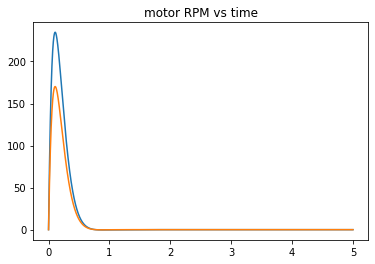

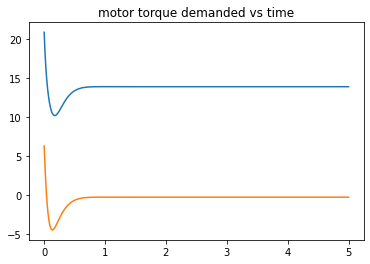

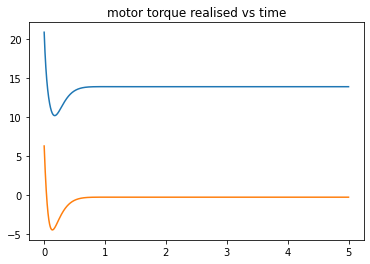

In [17]:
# opt_sample = np.array([6.91807585e-03, 5.44435793e-04, 3.28143369e+00, 1.59895149e+01,
#        1.84029964e+00, 2.33200843e+03, 2.35589212e+01, 6.09537226e+01,
#        1.09360919e+01, 1.85929336e-02, 2.20452583e-01, 3.58581821e-01,
#        7.19141155e-01, 4.57393703e-01, 6.06663155e-01, 1.02736512e-01])


# 40, 150, Singular matrix error
# opt_sample = np.array([7.96143308e-03, 3.36910845e-03, 3.94727839e+00, 4.74012394e+01,
#        2.82192349e+00, 2.08077837e+03, 2.08368058e+01, 6.01099903e+01,
#        1.88410482e+01, 3.88514060e-01, 2.94486612e-01, 3.66461430e-01,
#        3.28397450e-01, 3.76634459e-01, 7.23319206e-01, 1.34282196e-01,
#        1.08095971e+04, 2.00340487e+08, 3.53848956e+08])

# 3, 300 
# opt_sample = np.array([6.64716401e-03, 0.00000000e+00, 1.37096253e+00, 1.10292265e+01,
#        1.44508237e+00, 3.02143018e+03, 2.50000000e+01, 7.35519756e+01,
#        1.08684648e+01, 7.65727918e-01, 2.40561788e-01, 1.38711784e-01,
#        4.48576885e-01, 1.38789589e-01, 1.87717979e-01, 1.56116788e-01,
#        1.69232621e+04, 2.28930453e+08, 1.68806315e+08])

# 30, 150, error control
# opt_sample = np.array([8.56463949e-03, 2.41717386e-04, 2.81786362e+00, 1.32940246e+01,
#        2.41273378e+00, 3.54583616e+03, 2.49193397e+01, 7.67284037e+01,
#        1.32017787e+01, 1.63787830e+00, 1.73908215e-01, 4.05462599e-01,
#        8.25450860e-01, 4.14593783e-01, 8.55725276e-01, 1.47186740e-01,
#        1.64983127e+04, 1.82610214e+08, 1.51677526e+08])

# 10, 750, error control
# opt_sample = np.array([9.53879251e-03, 2.69658578e-03, 4.76413795e+00, 3.42204860e+01,
#        2.20700750e+00, 1.19888250e+03, 1.65240873e+01, 9.04692417e+01,
#        2.41572130e+01, 9.08769779e-01, 2.66998236e-01, 2.76143568e-01,
#        9.16581664e-01, 4.63879861e-01, 2.74830855e-01, 1.46614205e-01,
#        3.45667282e+03, 1.03240626e+08, 2.46728269e+06])

# opt_sample = np.array([0.0057857849071482875, 0.0, 1.6175622072824287, 30.0, 0.3919489602398743, 3140.511961626532,
#   25.0, 20.60346310039638, 10.0, 0.20668422373398593, 0.1, 0.39753344825851633, 0.6696554213945205, 0.5,
#   0.95, 0.172556429902661, 100.0, 379000000.0, 22491618.530260332])


# 10, 750, no error, 18hr wall time
opt_sample = np.array([7.59643468e-03, 0.00000000e+00, 3.85945462e+00, 1.61568531e+01,
       1.18077249e+00, 3.20282925e+03, 2.13285263e+01, 9.06534252e+01,
       1.72003275e+01, 1.50344975e+00, 1.00000000e-01, 1.05274237e-01,
       3.68761758e-01, 1.00000000e-01, 5.00000000e-02, 1.44383000e-01,
       1.24016242e+04, 2.78090215e+08, 3.38890725e+07])


results = compute_QoI(pre_val, dv_names, opt_sample, case, clf, fit_params, run_sim = True)
print(results)
K_w = np.diag([1e3,1,1,1,100,5,5,0])
# Quadratic objective meta function with weights
fitness_val = np.matmul(K_w, results).dot(results)
print(fitness_val)
# ([workspace, feasibility, deflection, payload, 
#   ts, total_friction_loss, total_joule_loss, final_error])

In [57]:
def gripper_forward_kinematics_example():
    urdf_path = './urdfs/AutoGen/divar3v835978448.urdf'
#     urdf_path = './urdfs/divar3v7757625049.urdf'
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    # Transform for the robot location
    X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1.3]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
    # Spawn table|
    table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
    # Spawn spherical work piece
    sphere = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere')
    X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), np.array([0, 0, 0.736]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere)[0]).body_frame(), X_R)

    plant.Finalize()
    
    end_frame = "eef"
    
    # Draw the frames
    for body_name in ["base_link", end_frame]:
        AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

    meshcat.Delete()
    meshcat.DeleteAddedControls()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    
    gripper = plant.GetBodyByName(end_frame)
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        print(pose.translation())
        clear_output(wait=True)
        print("gripper position (m): " + np.array2string(
            pose.translation(), formatter={
                'float': lambda x: "{:3.2f}".format(x)}))
        print("gripper roll-pitch-yaw (rad):" + np.array2string(
            RollPitchYaw(pose.rotation()).vector(),
                         formatter={'float': lambda x: "{:3.2f}".format(x)}))
        print("pose rotation: ", pose.rotation())
    sliders = MeshcatJointSlidersThatPublish(meshcat, plant, visualizer, context)
    # sliders.Run()
    sliders.Run(pose_callback)

gripper_forward_kinematics_example()

gripper position (m): [-0.46 -0.31 1.37]
gripper roll-pitch-yaw (rad):[1.28 0.20 1.29]
pose rotation:  RotationMatrix([
  [0.2710414349693712, -0.22182774469285746, 0.9366584181088773],
  [0.9413029638889925, 0.26449034564071244, -0.20974648325217368],
  [-0.20120951941581205, 0.9385293329179099, 0.2804949563702012],
])


In [ ]:
# carti = np.array([-0.53, 0.13, 0.81])
# orii = np.array([-3.14, 0, 1.35])
# qi = np.array([-0.64224017, -0.35515685, -1.01065151,  1.69796737, -0.2877014 ,0.87728685, -0.03373386])

# cartf = np.array([-0.23, 0.24, 1.03])
# orii = np.array([3.14, 0, 2.5])
# qi = np.array([0.27, 0, -2.4, 2, -0.5, 0.38, 0.64])